ResNet18, 34, 50, VIP, MVP, DINO

**We need to move the loading into the Compiled Models Notebook From Here**

In [1]:
from pathlib import Path
import zarr
from tqdm import trange


import torch
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

from src.models.generate_embeddings import generate_embeddings

# Check if CUDA is available and set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Device:", device)

Device: cuda


In [2]:
from src.models.encoders import models

**All Files Loading Info**


In [3]:
# NOTE: Change this to wherever the project is located in your google drive
project_root = Path("/home/ubuntu/semrep")
# project_root = Path("/content/drive/MyDrive/17 – Research/sim-2-real-representation-learning") # Lars
data_path = project_root / "data" / "processed"
models_path = project_root / "models"

# Output path
output_path = project_root / "embeddings" / "encoders"
output_path.mkdir(exist_ok=True)

In [4]:
# Load the data
sim = zarr.open(data_path / "one_leg_med_sim.zarr", mode="r")
real = zarr.open(data_path / "one_leg_low_real.zarr", mode="r")

datasets = {"sim": sim, "real": real}

for name, dataset in datasets.items():
    imgs = dataset["color_image2"]
    labels = dataset["action/pos"]

    print(
        f"Loaded {len(dataset['episode_ends'])} trajectories containing {imgs.shape[0]} frames of {name} data"
    )

Loaded 50 trajectories containing 24131 frames of sim data
Loaded 50 trajectories containing 27699 frames of real data


In [5]:
sim.tree()

Tree(nodes=(Node(disabled=True, name='/', nodes=(Node(disabled=True, name='action', nodes=(Node(disabled=True,…

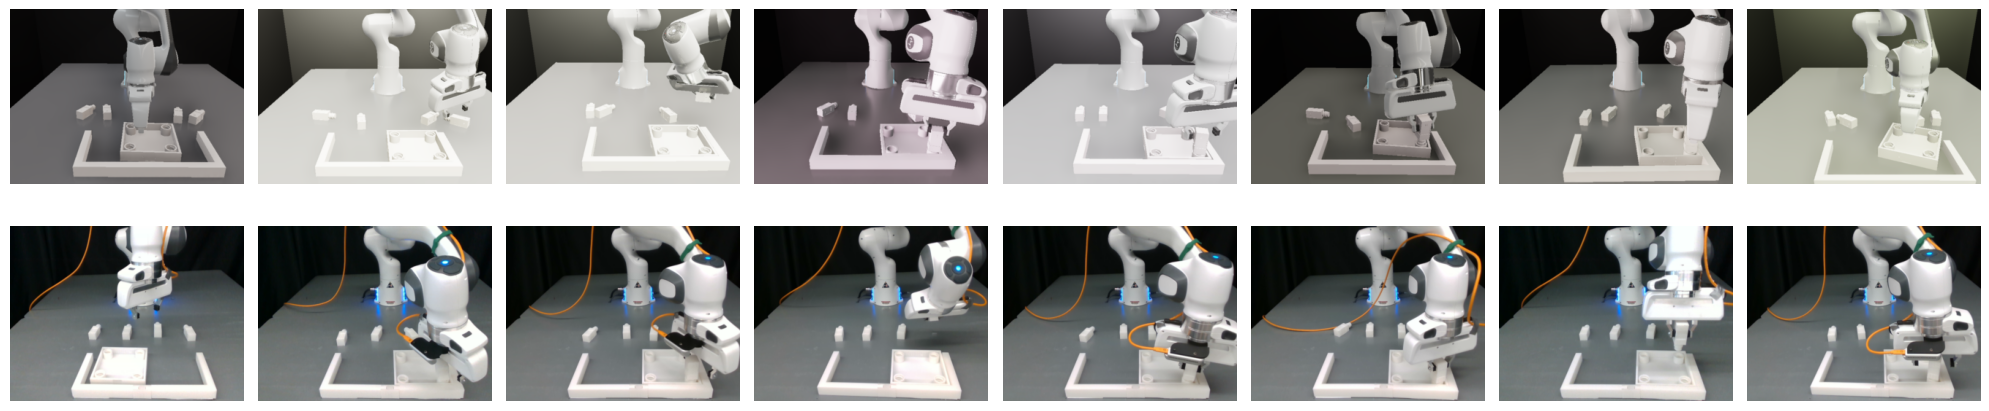

In [6]:
# Sample 8 images from each dataset
sim_indices = np.random.choice(datasets["sim"]["color_image2"].shape[0], size=8, replace=False)
real_indices = np.random.choice(datasets["real"]["color_image2"].shape[0], size=8, replace=False)

# Create a figure and axes
fig, axes = plt.subplots(2, 8, figsize=(20, 5))

# Display the sampled images
for i, idx in enumerate(sim_indices):
    axes[0, i].imshow(datasets["sim"]["color_image2"][idx])
    axes[0, i].axis("off")

for i, idx in enumerate(real_indices):
    axes[1, i].imshow(datasets["real"]["color_image2"][idx])
    axes[1, i].axis("off")

plt.tight_layout()
plt.show()

In [7]:
def process_dataset(m, dataset, dataset_type, num_samples=None, batch_size=1024):
    # Generate embeddings
    embeddings = generate_embeddings(
        m,
        dataset["color_image2"],
        num_samples=num_samples,
        batch_size=batch_size,
    ).numpy()

    # Make a split array for the embeddings into train and eval according to 90/10 split of trajectories
    split_index = dataset["episode_ends"][-5]

    # Split the embeddings into train and eval
    train_flag = np.zeros(embeddings.shape[0], dtype=bool)
    train_flag[:split_index] = True

    # Create a flag to indicate the dataset type (sim or real)
    dataset_flag = np.full(embeddings.shape[0], dataset_type, dtype=str)

    return embeddings, dataset["action/pos"], train_flag, dataset_flag

In [8]:
def process_all_models_and_datasets(models, datasets, device, batch_size=1024):
    results = {}

    print("Available models:", models.keys())

    for model_name, model_class in models.items():
        print(f"Processing with {model_name}")

        m: torch.nn.Module = model_class().to(device)

        # Process sim data
        sim_embeddings, sim_labels, sim_train_flag, sim_dataset_flag = process_dataset(
            m, datasets["sim"], "sim", batch_size=batch_size
        )

        # Process real data
        real_embeddings, real_labels, real_train_flag, real_dataset_flag = process_dataset(
            m, datasets["real"], "real", batch_size=batch_size
        )

        # Combine sim and real data
        combined_embeddings = np.vstack((sim_embeddings, real_embeddings))
        combined_labels = np.vstack((sim_labels, real_labels))
        combined_train_flag = np.concatenate((sim_train_flag, real_train_flag))
        combined_dataset_flag = np.concatenate((sim_dataset_flag, real_dataset_flag))

        # Store results for this model
        results = {
            "embeddings": combined_embeddings,
            "labels": combined_labels,
            "dataset_flag": combined_dataset_flag,
            "train_flag": combined_train_flag,
        }

        # Save the results
        output_file = output_path / f"{model_name}.npz"
        np.savez(
            output_file,
            **results,
        )

        print(f"Finished processing {model_name}")

    return results

In [9]:
models = {
    # "mcr": models["mcr"]
    # "Swin": models["Swin"],
    # "BEiT": models["BEiT"],
    # "CoAtNet": models["CoAtNet"],
    "vgg16": models["vgg16"],
}

In [ ]:
# Usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 512
all_results = process_all_models_and_datasets(models, datasets, device, batch_size=batch_size)

Available models: dict_keys(['vgg16'])
Processing with vgg16


Processing:   4%|▍         | 2/48 [00:05<02:04,  2.70s/it]

**Essential Usage Example**

In [ ]:
# Usage example for getting the size of training and val sets
file_path = "/home/ubuntu/semrep/embeddings/encoders/dinov2.npz"

from src.models.loadsplit import load_and_use_existing_split

train_data, val_data = load_and_use_existing_split(file_path)

# Now you can access the train and validation data like this:
train_embeddings = train_data["embeddings"]
train_labels = train_data["labels"]
train_dataset_flag = train_data["dataset_flag"]

val_embeddings = val_data["embeddings"]
val_labels = val_data["labels"]
val_dataset_flag = val_data["dataset_flag"]

# Print some information about the splits
print(f"Training set size: {len(train_embeddings)}")
print(f"Validation set size: {len(val_embeddings)}")

# Check the distribution of sim vs real data in each split
print(
    f"Training set - Sim data: {np.sum(train_dataset_flag == 's')}, Real data: {np.sum(train_dataset_flag == 'r')}"
)
print(
    f"Validation set - Sim data: {np.sum(val_dataset_flag == 's')}, Real data: {np.sum(val_dataset_flag == 'r')}"
)

Training set size: 47432
Validation set size: 4398
Training set - Sim data: 22021, Real data: 25411
Validation set - Sim data: 2110, Real data: 2288


In [ ]:
# example of selecting all embeddings instead of the split
dataset = np.load(file_path)
embeddings = dataset["embeddings"]